In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from interface import Calibrator, DefaultCalibrator, mass_calibration, mass_calibration_with_default, analyze_models_for_item, analyze_default_models_for_item
from data import date_handler, today, test_dates, ios, swap, germany, france, italy
from calibration import squared, relative_squared

# RNG Seeding
gen_seed, opt_seed = 42, 89453934320

# Models to be run
models = [((0, 0, 1),(0, 1, 0)),
          ((0, 0, 1),(1, 0, 0)),
          ((1, 0, 0),(1, 0, 0)),
          ((1, 0, 0),(0, 1, 0)),
          ((0, 0, 0),(0, 1, 1)),
          ((0, 0, 0),(1, 1, 0))]
def_results = {}

location_of_pickled_data = 'C:/Users/Miikka/PycharmProjects/gradu/'

# Change to True if you want the results to be run
ios_swap_run = False
ios_italy_run = False
germany_france_run = False
germany_italy_run = False


# Difference function
use_straight_squared = False

if use_straight_squared:
    diff_fun = squared
    data_pickle = 'data.pickle'
    def_data_pickle = 'def_data.pickle'
    
else:
    diff_fun = relative_squared
    data_pickle = 'data_rel.pickle'
    def_data_pickle = 'def_data_rel.pickle'

# LGD
LGD = None


# Open the old pickled data
if os.path.isfile(location_of_pickled_data + data_pickle):
    with open(location_of_pickled_data + data_pickle, 'rb') as f:
        results = pickle.load(f)
        

# Open the old pickled data
if os.path.isfile(location_of_pickled_data + def_data_pickle):
    with open(location_of_pickled_data + def_data_pickle, 'rb') as f:
        def_results = pickle.load(f)
        
def picked_save(location, pickle_file, results):
    
    with open(location + pickle_file, 'wb') as f:
        pickle.dump(results, f)
        
# Run the calibrations
if ios_swap_run:

    key, riskfree_data, risky_data = 'ios, swap', ios, swap

    mass_calibration_with_default(key=key, 
                                  riskfree_data=riskfree_data, 
                                  risky_data=risky_data, 
                                  LGD=LGD, 
                                  diff_fun=diff_fun,
                                  gen_seed=gen_seed, 
                                  opt_seed=opt_seed, 
                                  results=def_results, 
                                  models=models)
    
    picked_save(location_of_pickled_data, def_data_pickle, def_results)
    
if ios_italy_run:

    key, riskfree_data, risky_data = 'ios, italy', ios, italy

    mass_calibration_with_default(key=key, 
                                  riskfree_data=riskfree_data, 
                                  risky_data=risky_data, 
                                  LGD=LGD, 
                                  diff_fun=diff_fun,
                                  gen_seed=gen_seed, 
                                  opt_seed=opt_seed, 
                                  results=def_results, 
                                  models=models)
    
    picked_save(location_of_pickled_data, def_data_pickle, def_results)
      
if germany_france_run:

    key, riskfree_data, risky_data = 'germany, france', germany, france
    
    models2 = copy.copy(models)
    models.remove(((1, 0, 0),(0, 1, 0)))

    mass_calibration_with_default(key=key, 
                                  riskfree_data=riskfree_data, 
                                  risky_data=risky_data, 
                                  LGD=LGD, 
                                  diff_fun=diff_fun,
                                  gen_seed=gen_seed, 
                                  opt_seed=opt_seed, 
                                  results=def_results, 
                                  models=models)
    
    picked_save(location_of_pickled_data, def_data_pickle, def_results)
    
if germany_italy_run:

    key, riskfree_data, risky_data = 'germany, italy', germany, italy

    mass_calibration_with_default(key=key, 
                                  riskfree_data=riskfree_data, 
                                  risky_data=risky_data, 
                                  LGD=LGD, 
                                  diff_fun=diff_fun,
                                  gen_seed=gen_seed, 
                                  opt_seed=opt_seed, 
                                  results=def_results, 
                                  models=models)
    
    picked_save(location_of_pickled_data, def_data_pickle, def_results)
    


In [6]:
def_results['ios, swap'][((0,0,1),(0,1,0))].keys()

dict_keys(['param', 'riskfree', 'risky', 'res', 'res_evo', 'duration'])

In [2]:
mod_results = {}
data = dict(Base={}, Defaultable={})

for item in def_results:

    if item == 'ios, swap':
        item_name = 'OISvsSWAP'
    elif item == 'ios, italy':
        item_name = 'OISvsITA'
    elif item == 'germany, france':
        item_name = 'GERvsFRA'
    elif item == 'germany, italy':
        item_name = 'GERvsITA'
        
    mod_results[item_name] = {}
    data['Base'][item_name] = {}
    data['Defaultable'][item_name] = {}
        
    for model in def_results[item]:
        Ms, Ns = model
        model_name = f'D(({Ms[0]}, {Ms[1]}, {Ms[2]}),({Ns[0]}, {Ns[1]}, {Ns[2]}))'
        mod_results[item_name][model_name] = {}
        param = def_results[item][model]['param']
        for key in param:
            if key not in ('M', 'N', 'shift', 'risk_free', 'a_m', 'b_m', 'c_i', 'd_i'):
                value = param[key]
                if isinstance(value, np.ndarray):
                    if value.shape == (1,):
                        value = value[0]

                key2 = key
               
                if key == 'rho':
                    if value.shape == (2,2):
                        value = value[0,1]
                    elif value.shape == (3,3):
                        value = [value[0,1], value[0,2], value[1,2]]
                mod_results[item_name][model_name][key2] = np.round(value, 3)
                
        data['Base'][item_name][model_name] = def_results[item][model]['riskfree']
        data['Defaultable'][item_name][model_name] = def_results[item][model]['risky']
        
    data['Base'][item_name] = pd.concat(data['Base'][item_name])
    data['Defaultable'][item_name] = pd.concat(data['Defaultable'][item_name])
    
data['Base'] = pd.concat(data['Base'])
data['Defaultable'] = pd.concat(data['Defaultable'])

data = pd.concat(data)
df = data.reset_index()
df.columns = ['Type', 'Instruments', 'Model', 'Date'] + list(df.columns[4:-2]) + ['Relative error', 'Absolute error']
df[['Market price', 'Calibrated price', 'Difference', 'Abs difference', 'Relative error', 'Absolute error']] = df[['Market price', 'Calibrated price', 'Difference', 'Abs difference', 'Relative error', 'Absolute error']].astype(float)


In [115]:
df


Type Instruments                   Model        Date  \
0           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2019-01-30   
1           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2021-07-30   
2           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2023-07-31   
3           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2026-07-30   
4           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2028-07-31   
5           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2038-07-30   
6           Base    GERvsFRA  D((0, 0, 0),(0, 1, 1))  2048-07-30   
7           Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2019-01-30   
8           Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2021-07-30   
9           Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2023-07-31   
10          Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2026-07-30   
11          Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2028-07-31   
12          Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2038-07-30   
13          Base    GERvsFRA  D((0, 0, 0),(1, 1, 0))  2048-07-30   
14          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2019-01-30   
15          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2021-07-30   
16          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2023-07-31   
17          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2026-07-30   
18          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2028-07-31   
19          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2038-07-30   
20          Base    GERvsFRA  D((0, 0, 1),(0, 1, 0))  2048-07-30   
21          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2019-01-30   
22          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2021-07-30   
23          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2023-07-31   
24          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2026-07-30   
25          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2028-07-31   
26          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2038-07-30   
27          Base    GERvsFRA  D((0, 0, 1),(1, 0, 0))  2048-07-30   
28          Base    GERvsFRA  D((1, 0, 0),(1, 0, 0))  2019-01-30   
29          Base    GERvsFRA  D((1, 0, 0),(1, 0, 0))  2021-07-30   
..           ...         ...                     ...         ...   
405  Defaultable   OISvsSWAP  D((0, 0, 1),(1, 0, 0))  2028-07-31   
406  Defaultable   OISvsSWAP  D((0, 0, 1),(1, 0, 0))  2033-07-29   
407  Defaultable   OISvsSWAP  D((0, 0, 1),(1, 0, 0))  2038-07-30   
408  Defaultable   OISvsSWAP  D((0, 0, 1),(1, 0, 0))  2048-07-30   
409  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2018-07-27   
410  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2018-08-06   
411  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2018-08-30   
412  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2018-10-30   
413  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2019-01-30   
414  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2019-07-30   
415  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2021-07-30   
416  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2023-07-31   
417  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2026-07-30   
418  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2028-07-31   
419  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2033-07-29   
420  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2038-07-30   
421  Defaultable   OISvsSWAP  D((1, 0, 0),(0, 1, 0))  2048-07-30   
422  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2018-07-27   
423  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2018-08-06   
424  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2018-08-30   
425  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2018-10-30   
426  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2019-01-30   
427  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2019-07-30   
428  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2021-07-30   
429  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2023-07-31   
430  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2026-07-30   
431  Defaultable   OISvsSWAP  D((1, 0, 0),(1, 0, 0))  2028-07-31   


In [2]:
for instruments in set(df['Instruments']):

    sns.set(style='whitegrid')
    g = sns.FacetGrid(df[df['Instruments'] == instruments], 
                      col='Instruments', 
                      row='Model', 
                      hue='Type',
                      height=5, 
                      aspect=2.5, 
                      palette='Set1')
    g = (g.map(sns.lineplot, 'Date', 'Relative error', marker='o').add_legend())

NameError: name 'df' is not defined

Model                   Type       
D((0, 0, 0),(0, 1, 1))  Base           0.535691
                        Defaultable    0.562353
D((0, 0, 0),(1, 1, 0))  Base           0.678225
                        Defaultable    0.582391
D((0, 0, 1),(0, 1, 0))  Base           0.432809
                        Defaultable    0.396539
D((0, 0, 1),(1, 0, 0))  Base           0.577896
                        Defaultable    0.353020
D((1, 0, 0),(0, 1, 0))  Base           0.410545
                        Defaultable    0.354307
D((1, 0, 0),(1, 0, 0))  Base           0.645198
                        Defaultable    0.641642
dtype: float64

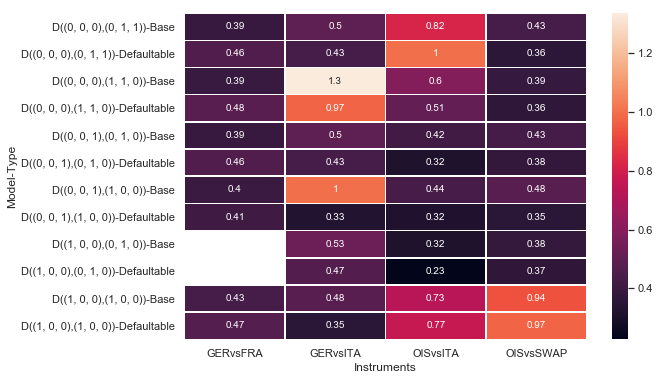

In [3]:
df.groupby(by=['Type', 'Instruments', 'Model']).mean()
errors = df.pivot_table(index=['Instruments', 'Date'], columns=['Type', 'Model'], values='Absolute error').mean(level=0).transpose().swaplevel().sort_index()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(errors, annot=True, linewidths=.5, ax=ax)

errors.mean(axis=1)

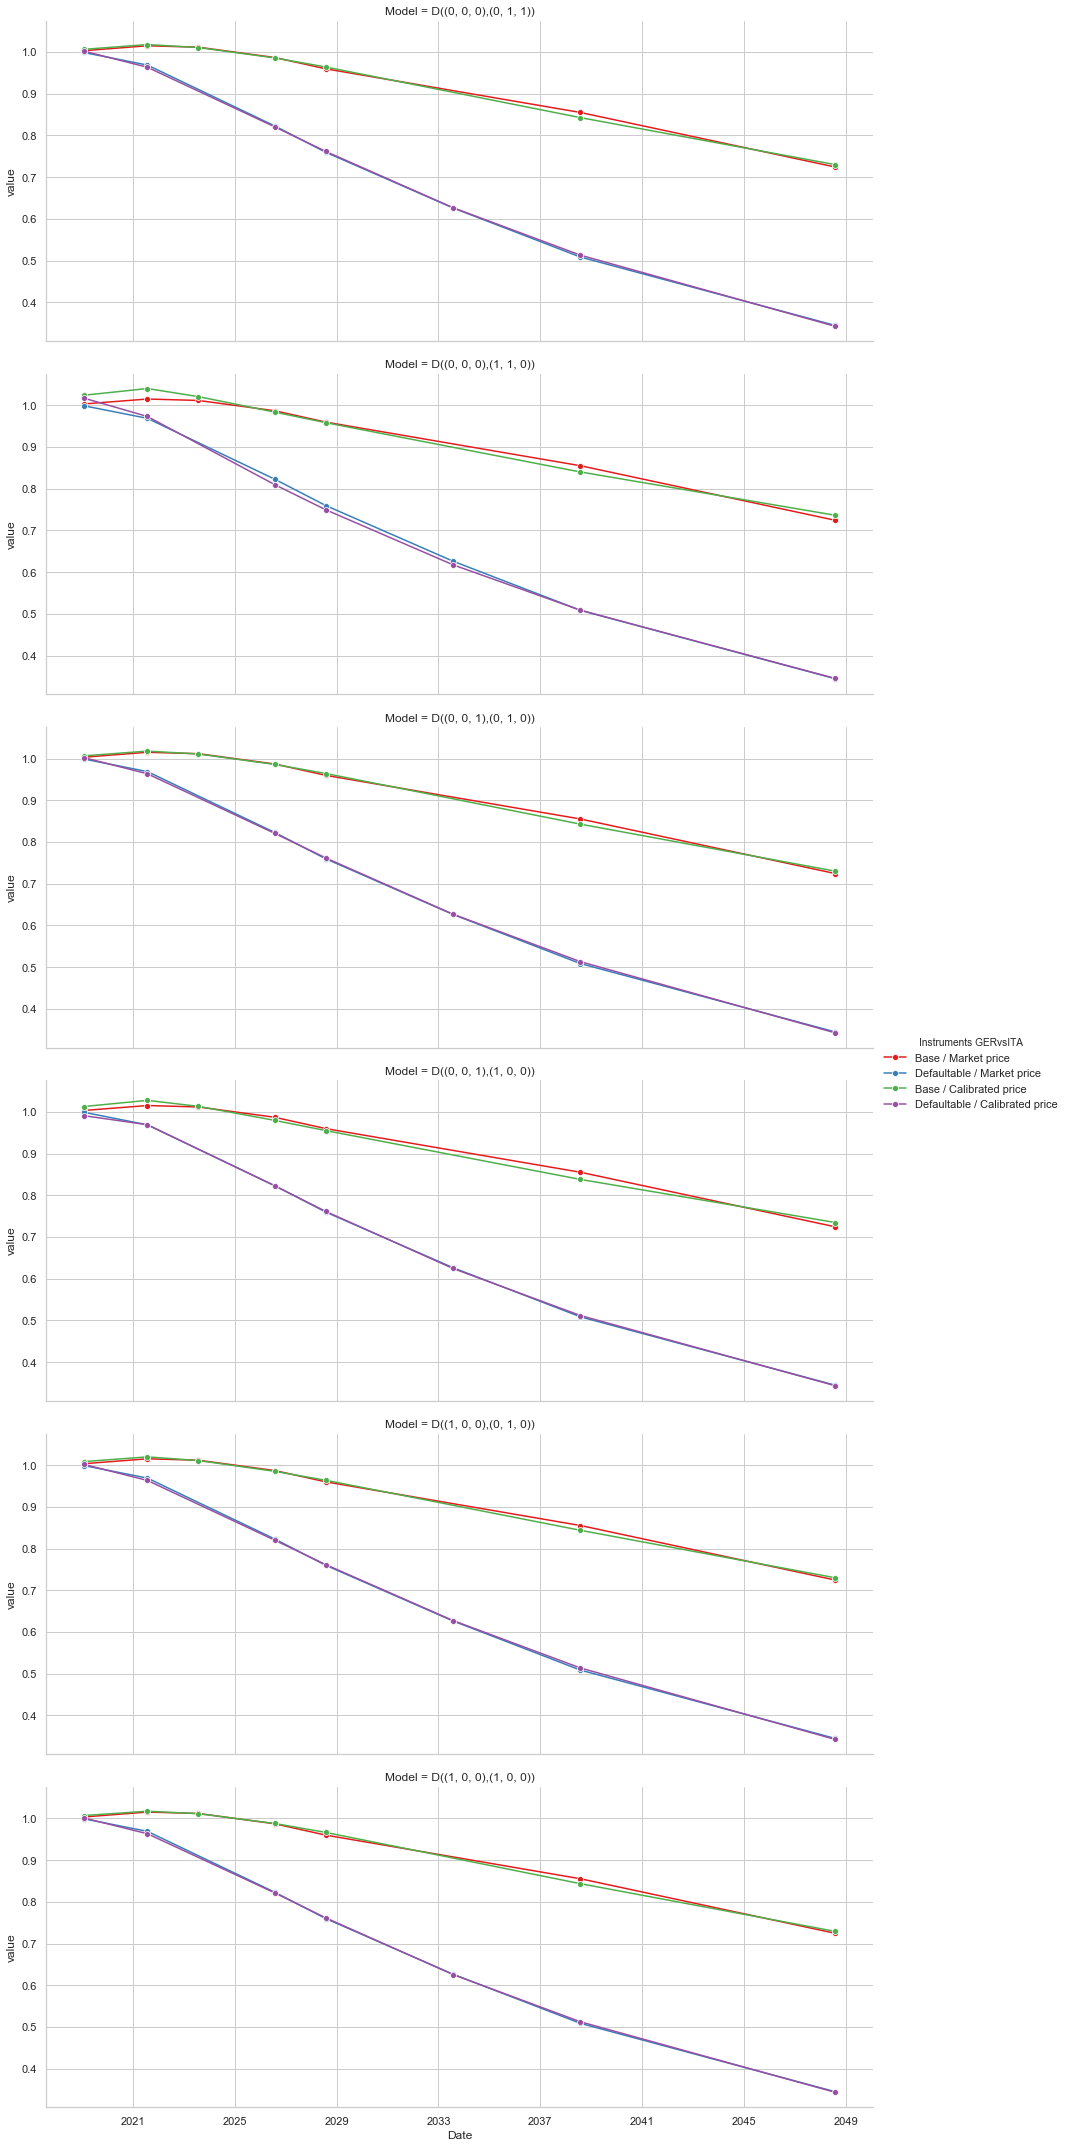

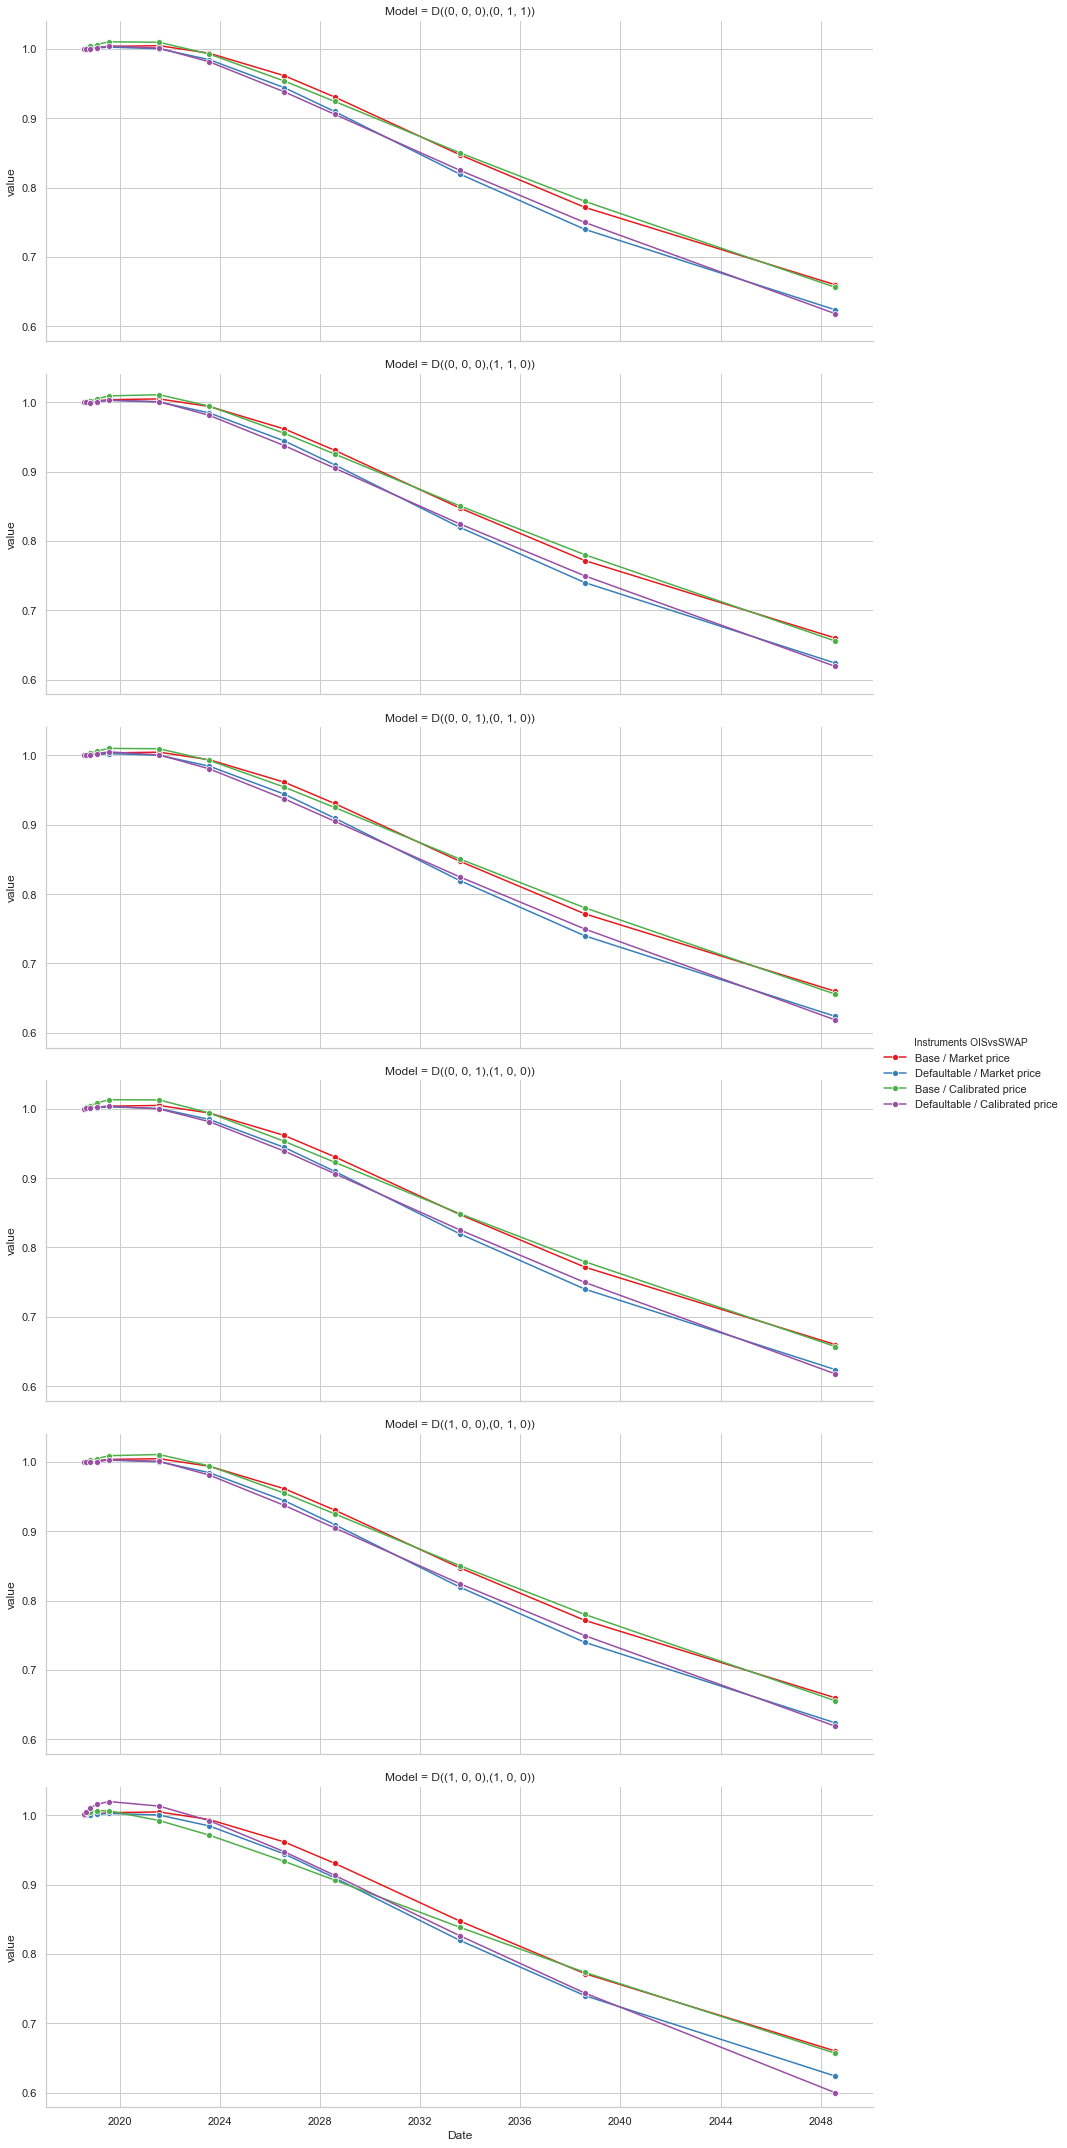

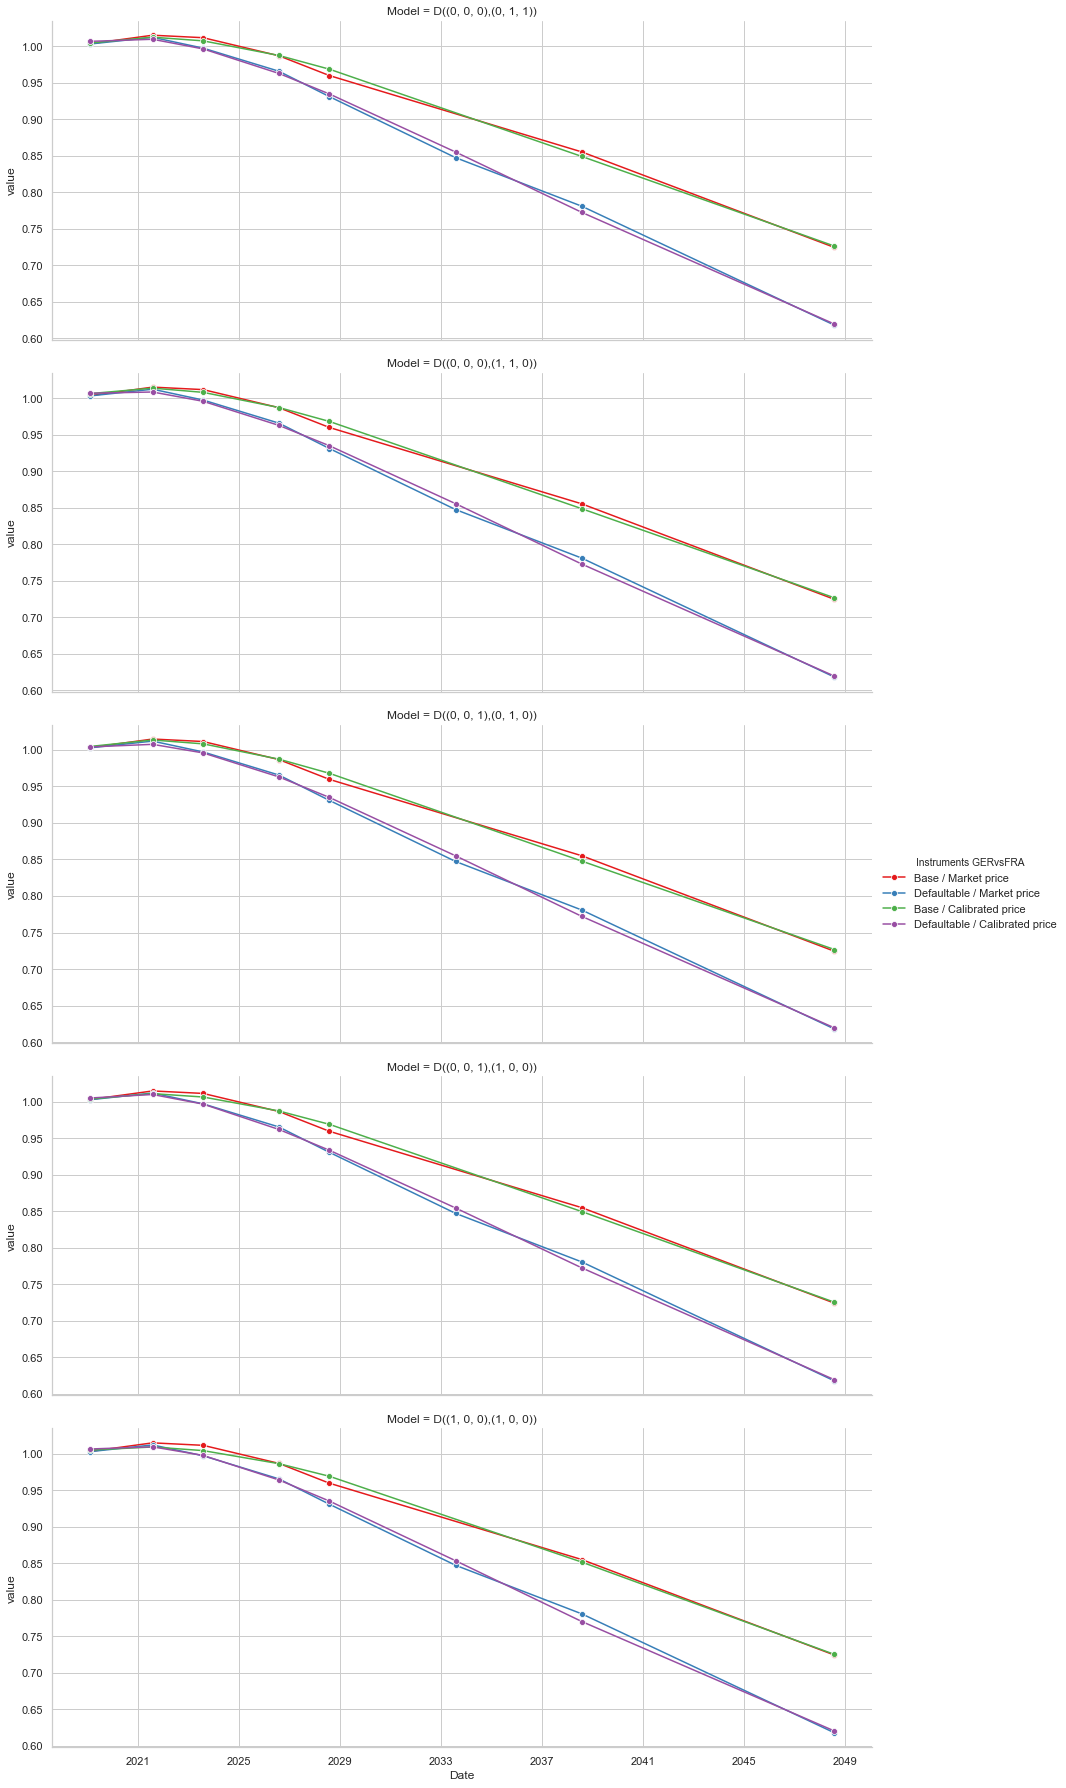

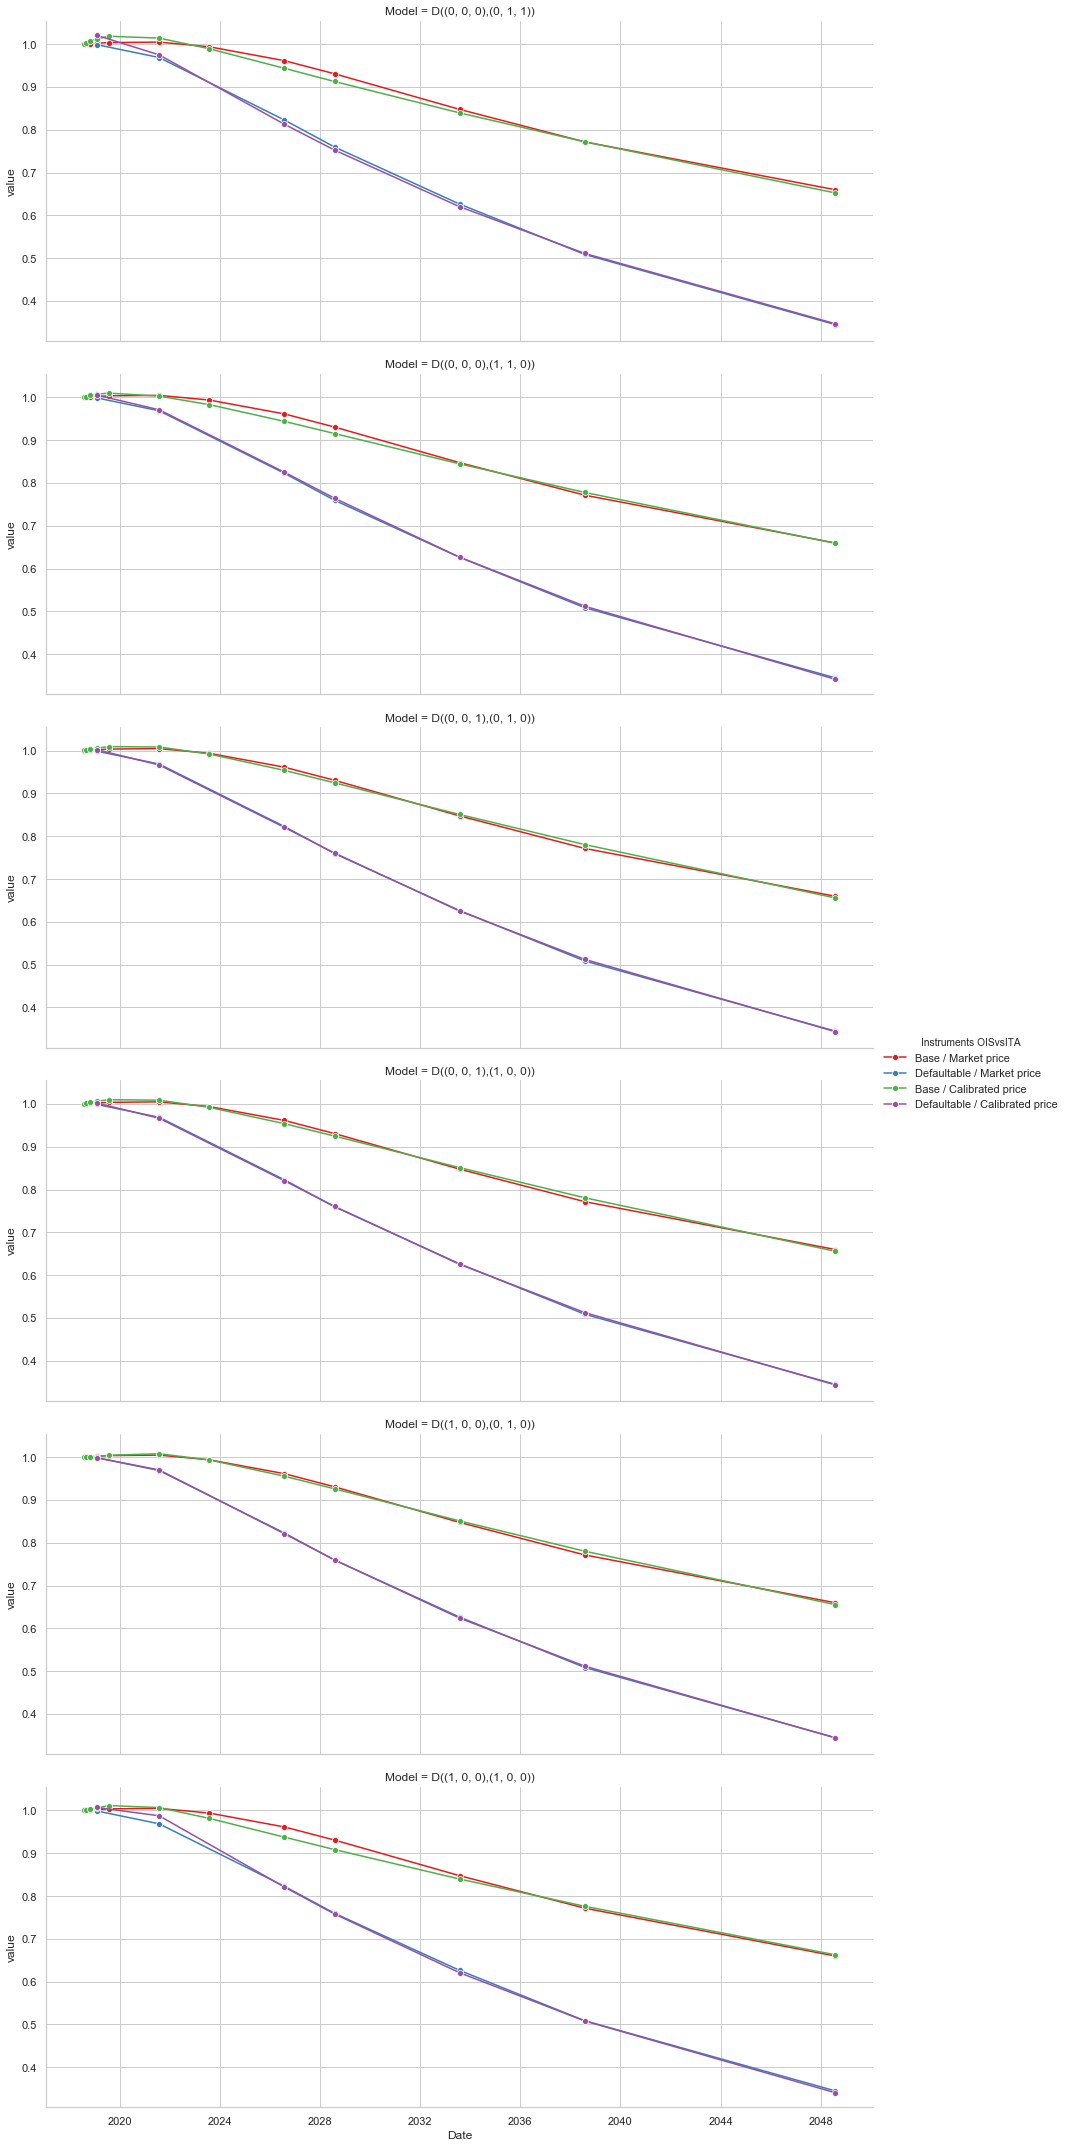

In [124]:
df2 = df.iloc[: , :6]
df2 = df2.melt(id_vars=df2.columns[:4], value_vars=df2.columns[4:6], var_name='Price')
df2['Typing'] = df2['Type'] + ' / ' + df2['Price']



for instruments in set(df2['Instruments']):

    sns.set(style='whitegrid')

    g = sns.FacetGrid(df2[df2['Instruments'] == instruments], 
                      row='Model', 
                      hue='Typing', 
                      height=5, 
                      aspect=2.5, 
                      palette='Set1')
    g = (g.map(sns.lineplot, 'Date', 'value', marker='o').add_legend(title=f'Instruments {instruments}'))


In [133]:
mod_results

{'OISvsSWAP': {'D((0, 0, 1),(0, 1, 0))': {'delta': 0.017,
   'spread': 0.002,
   'alpha': 3.0,
   'theta': 0.0,
   'sigma': 0.041,
   'X_0': 0.01,
   'k': 0.314,
   'nu': 0.001,
   'Y_0': -0.032,
   'LGD': 0.97},
  'D((0, 0, 1),(1, 0, 0))': {'delta': 0.017,
   'spread': 0.002,
   'alpha': 0.544,
   'theta': 0.0,
   'sigma': 0.041,
   'X_0': 0.047,
   'k': 0.384,
   'nu': 0.002,
   'Y_0': -0.036,
   'LGD': 0.426},
  'D((1, 0, 0),(1, 0, 0))': {'delta': 0.005,
   'spread': 0.002,
   'alpha': 0.228,
   'theta': 0.015,
   'sigma': 0.032,
   'X_0': 0.001,
   'k': 2.508,
   'nu': 0.219,
   'Y_0': -0.033,
   'LGD': 0.441},
  'D((1, 0, 0),(0, 1, 0))': {'delta': 0.017,
   'spread': 0.002,
   'alpha': 2.857,
   'theta': 0.0,
   'sigma': 0.161,
   'X_0': 0.013,
   'k': 0.342,
   'nu': 0.001,
   'Y_0': -0.036,
   'LGD': 0.435},
  'D((0, 0, 0),(0, 1, 1))': {'delta': 0.017,
   'spread': 0.004,
   'k': array([0.321, 2.727]),
   'nu': array([0.007, 0.25 ]),
   'rho': -0.99,
   'Y_0': array([-0.032,  0.

Running these calibrations took 27.71 minutes.
Absolute relative errors by models for risk-free:
(0, 0, 1)  (1, 0, 0)   -0.145790
           (0, 1, 0)   -0.109471
(0, 0, 0)  (0, 1, 1)   -0.100032
           (1, 1, 0)   -0.094683
(1, 0, 0)  (0, 1, 0)   -0.089939
           (1, 0, 0)    0.689941
dtype: float64
Absolute relative errors by models for risky:
(1, 0, 0)  (1, 0, 0)   -0.381823
(0, 0, 1)  (0, 1, 0)   -0.000772
           (1, 0, 0)    0.003117
(0, 0, 0)  (0, 1, 1)    0.005083
           (1, 1, 0)    0.056650
(1, 0, 0)  (0, 1, 0)    0.057948
dtype: float64
Combined absolute relative errors by models:
(0, 0, 0)  (1, 1, 0)    0.373995
(1, 0, 0)  (0, 1, 0)    0.375183
(0, 0, 0)  (0, 1, 1)    0.393532
(0, 0, 1)  (0, 1, 0)    0.401943
           (1, 0, 0)    0.413910
(1, 0, 0)  (1, 0, 0)    0.952938
dtype: float64
Running these calibrations took 19.23 minutes.
Absolute relative errors by models for risk-free:
(0, 0, 1)  (1, 0, 0)   -0.090439
           (0, 1, 0)   -0.081002
(1, 0, 0) 

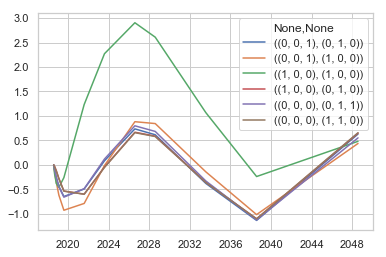

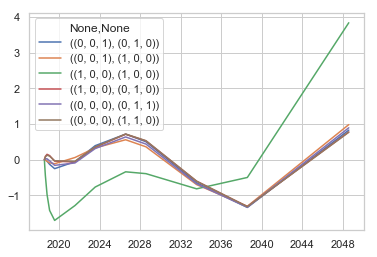

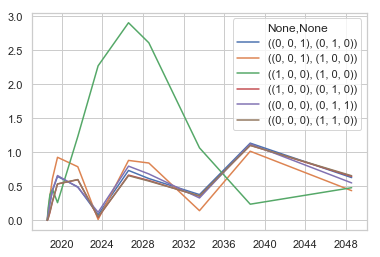

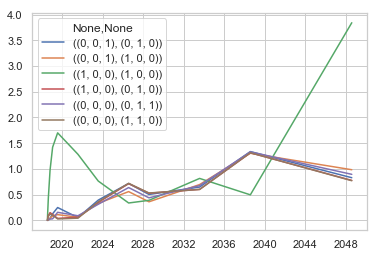

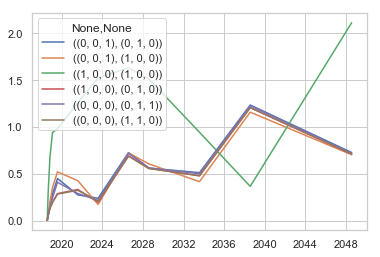

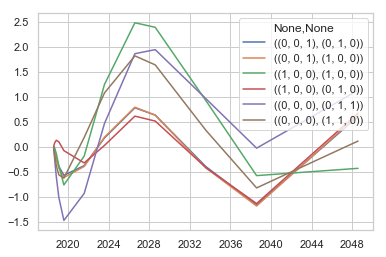

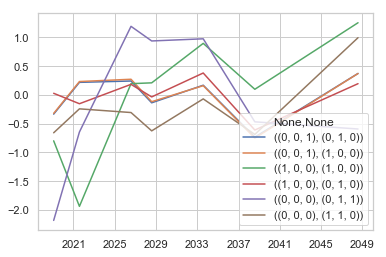

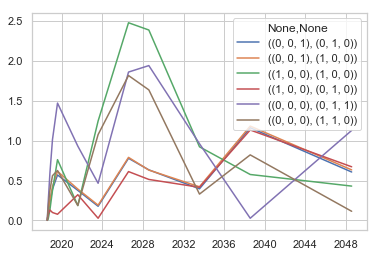

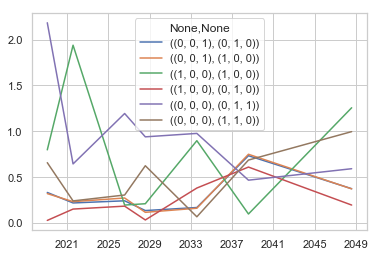

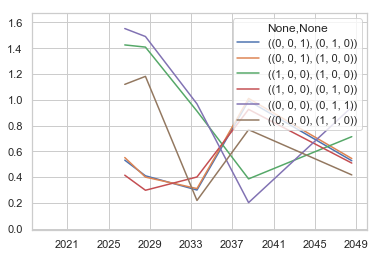

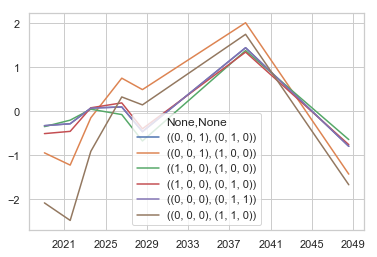

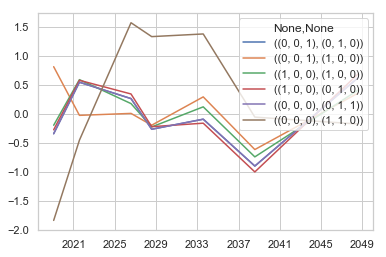

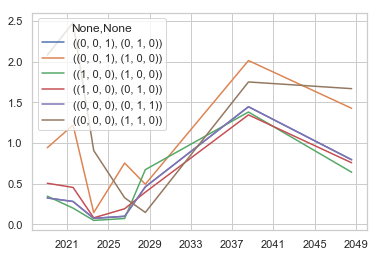

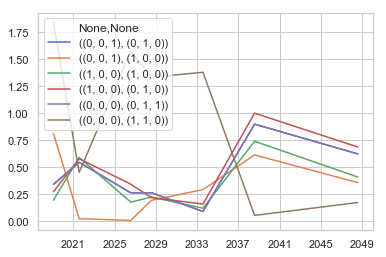

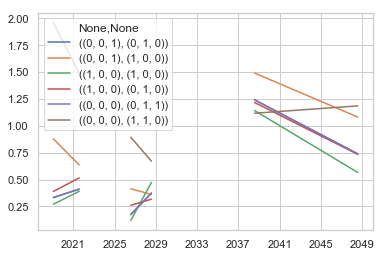

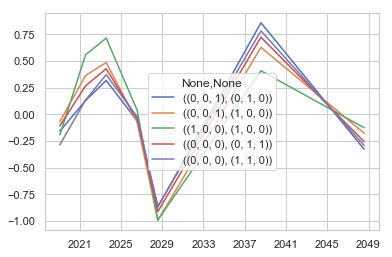

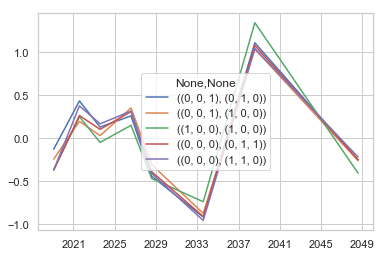

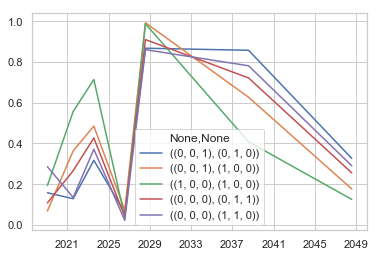

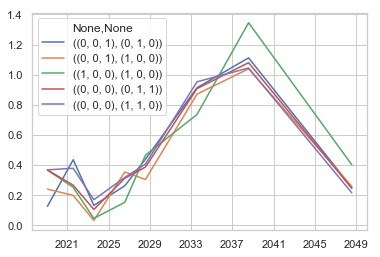

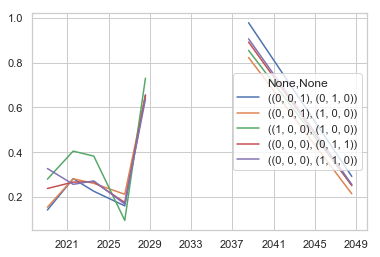

In [38]:
relatives_rf, absolutes_rf = {}, {}
relatives_risky, absolutes_risky = {}, {}
relative_rf_data, relative_risky_data = {}, {}
absolute_rf_data, absolute_risky_data = {}, {}
for item in def_results:
    if item == 'ios, swap':
        item2 = 'OIS, Swap'
    elif item == 'ios, italy':
        item2 = 'OIS, Italy'
    elif item == 'germany, france':
        item2 = 'Germany, France'
    elif item == 'germany, italy':
        item2 = 'Germany, Italy'
        
    absolute, relative_rf, relative_risky, absolute_rf, absolute_risky, param, durations = analyze_default_models_for_item(item, def_results)
    relatives_rf[item2] = np.round(relative_rf.mean(), 2)
    absolutes_rf[item2] = np.round(absolute_rf.mean(), 2)
    relatives_risky[item2] = np.round(relative_risky.mean(), 2)
    absolutes_risky[item2] = np.round(absolute_risky.mean(), 2)
    relative_rf.columns = [ f'({Ms[0]}, {Ms[1]}, {Ms[2]}),({Ns[0]}, {Ns[1]}, {Ns[2]})' for Ms, Ns in relative_rf.columns]
    relative_rf_data[item2] = relative_rf.astype(float).round(decimals=3)
    absolute_rf.columns = [ f'({Ms[0]}, {Ms[1]}, {Ms[2]}),({Ns[0]}, {Ns[1]}, {Ns[2]})' for Ms, Ns in absolute_rf.columns]
    absolute_rf_data[item2] = absolute_rf.astype(float).round(decimals=3)
    relative_risky.columns = [ f'({Ms[0]}, {Ms[1]}, {Ms[2]}),({Ns[0]}, {Ns[1]}, {Ns[2]})' for Ms, Ns in relative_risky.columns]
    relative_risky_data[item2] = relative_risky.astype(float).round(decimals=3)
    absolute_risky.columns = [ f'({Ms[0]}, {Ms[1]}, {Ms[2]}),({Ns[0]}, {Ns[1]}, {Ns[2]})' for Ms, Ns in absolute_risky.columns]
    absolute_risky_data[item2] = absolute_risky.astype(float).round(decimals=3)

In [21]:
pd.DataFrame(absolutes_rf)

ios, swap  ios, italy  germany, italy  germany, france
(0, 0, 0) (0, 1, 1)       0.43        0.82            0.50             0.39
          (1, 1, 0)       0.39        0.60            1.34             0.39
(0, 0, 1) (0, 1, 0)       0.43        0.42            0.50             0.39
          (1, 0, 0)       0.48        0.44            1.00             0.40
(1, 0, 0) (0, 1, 0)       0.38        0.32            0.53              NaN
          (1, 0, 0)       0.94        0.73            0.48             0.43

In [39]:
pd.DataFrame(absolutes_risky)

OIS, Swap  OIS, Italy  Germany, Italy  Germany, France
(0, 0, 0) (0, 1, 1)       0.36        1.00            0.43             0.46
          (1, 1, 0)       0.36        0.51            0.97             0.48
(0, 0, 1) (0, 1, 0)       0.38        0.32            0.43             0.46
          (1, 0, 0)       0.35        0.32            0.33             0.41
(1, 0, 0) (0, 1, 0)       0.37        0.23            0.47              NaN
          (1, 0, 0)       0.97        0.77            0.35             0.47

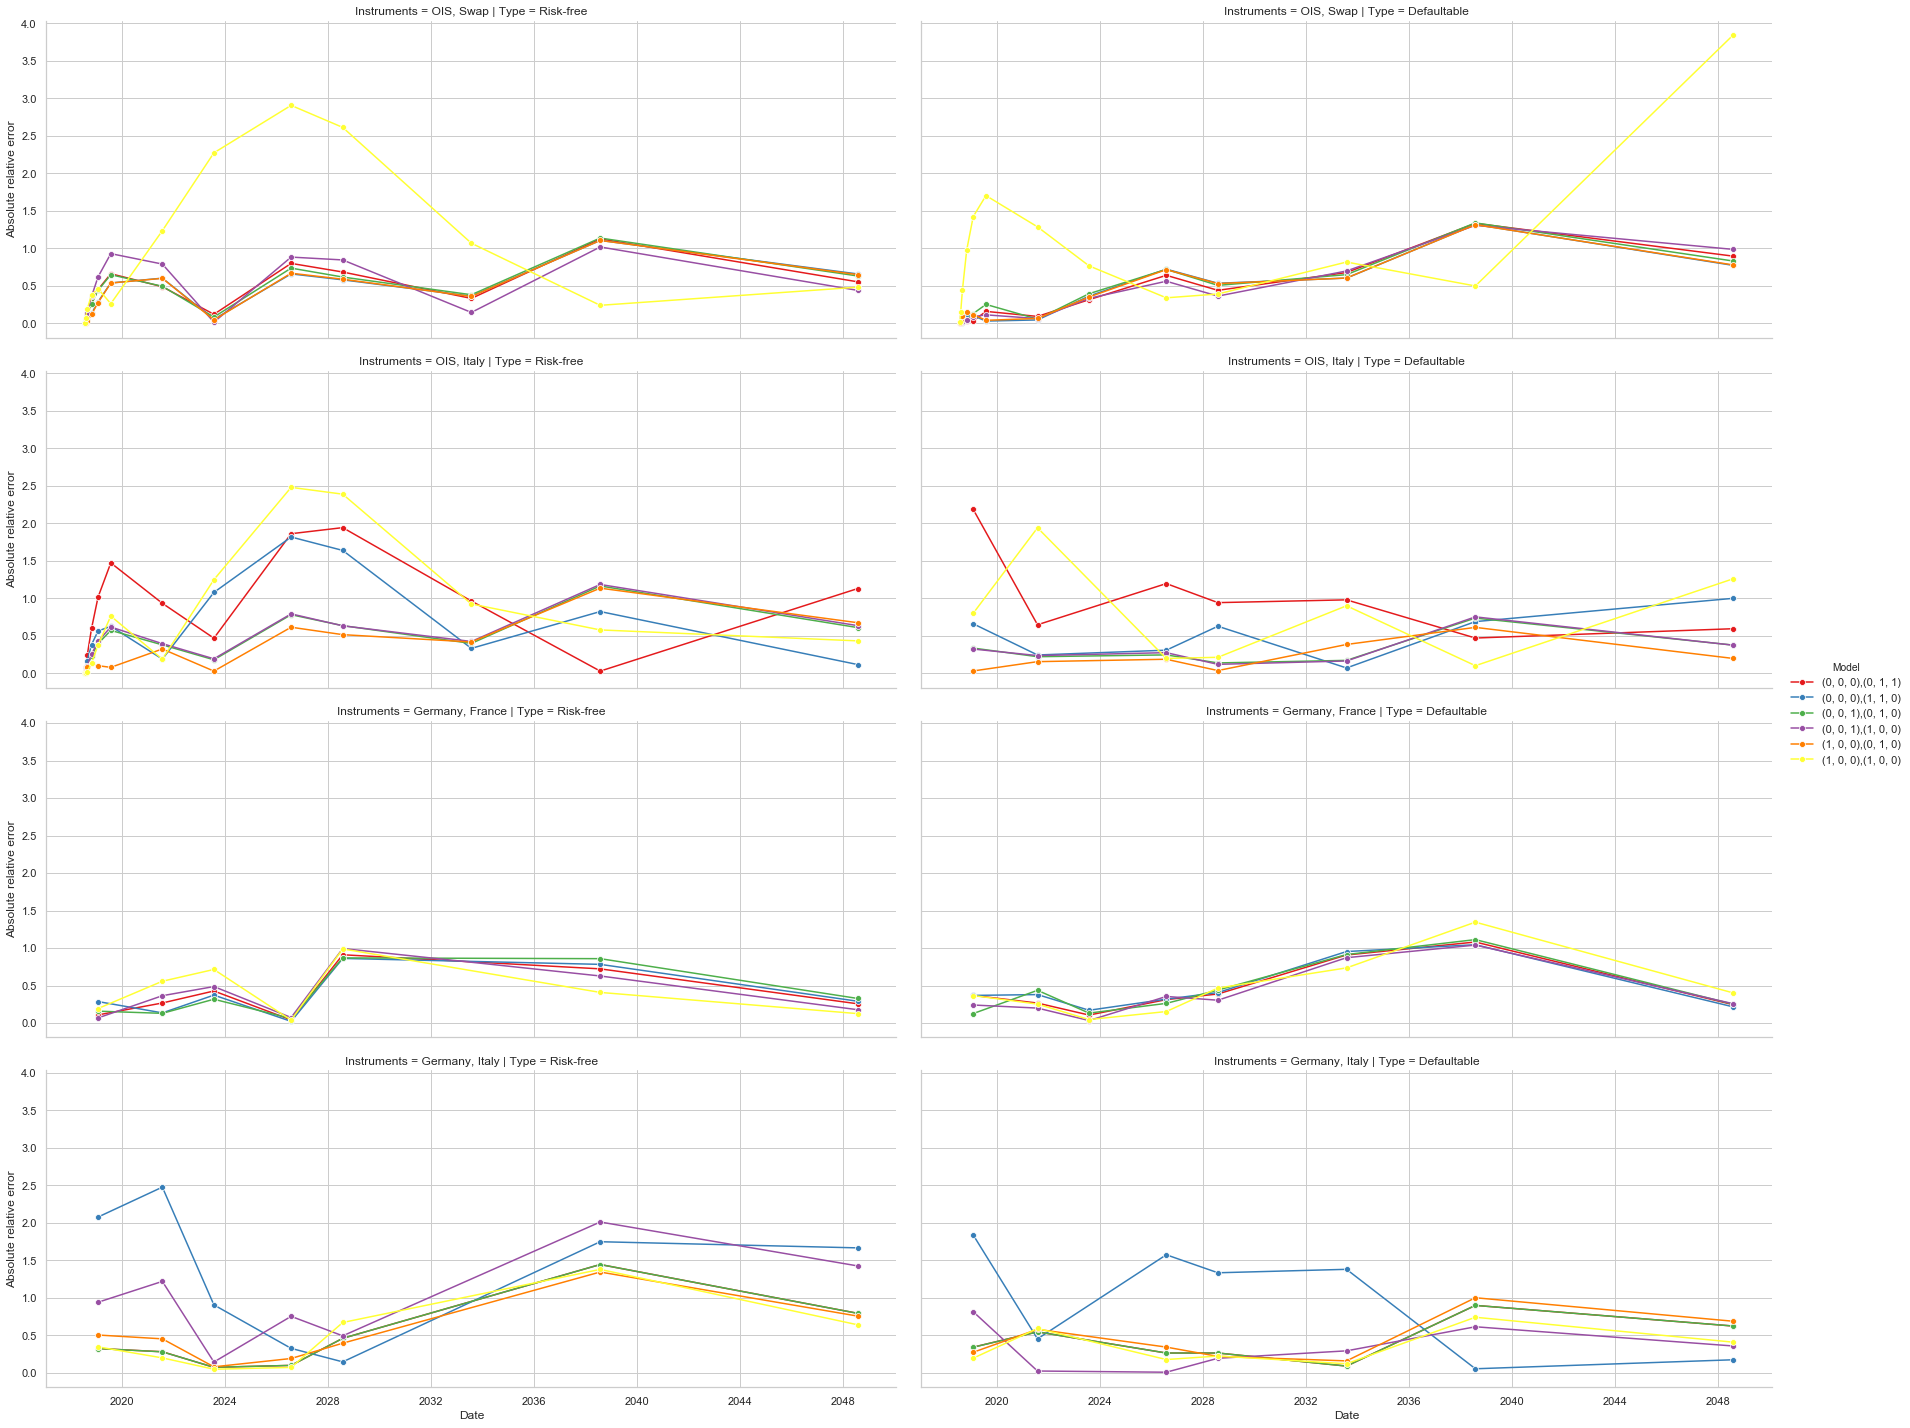

In [49]:
df = pd.concat([pd.concat(absolute_rf_data, sort=True), pd.concat(absolute_risky_data, sort=True)], keys=['Risk-free', 'Defaultable'])
df = df.reset_index()
df.columns = ['Type', 'Instruments', 'Date'] + list(df.columns)[3:]
df = pd.melt(df, value_vars=df.columns[3:], id_vars=df.columns[:3], var_name='Model', value_name='Absolute relative error')

g = sns.FacetGrid(df, 
                  col='Type', 
                  row='Instruments', 
                  hue='Model', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1',
                  row_order=['OIS, Swap', 'OIS, Italy', 'Germany, France', 'Germany, Italy'])
g = (g.map(sns.lineplot, 'Date', 'Absolute relative error', marker='o').add_legend())

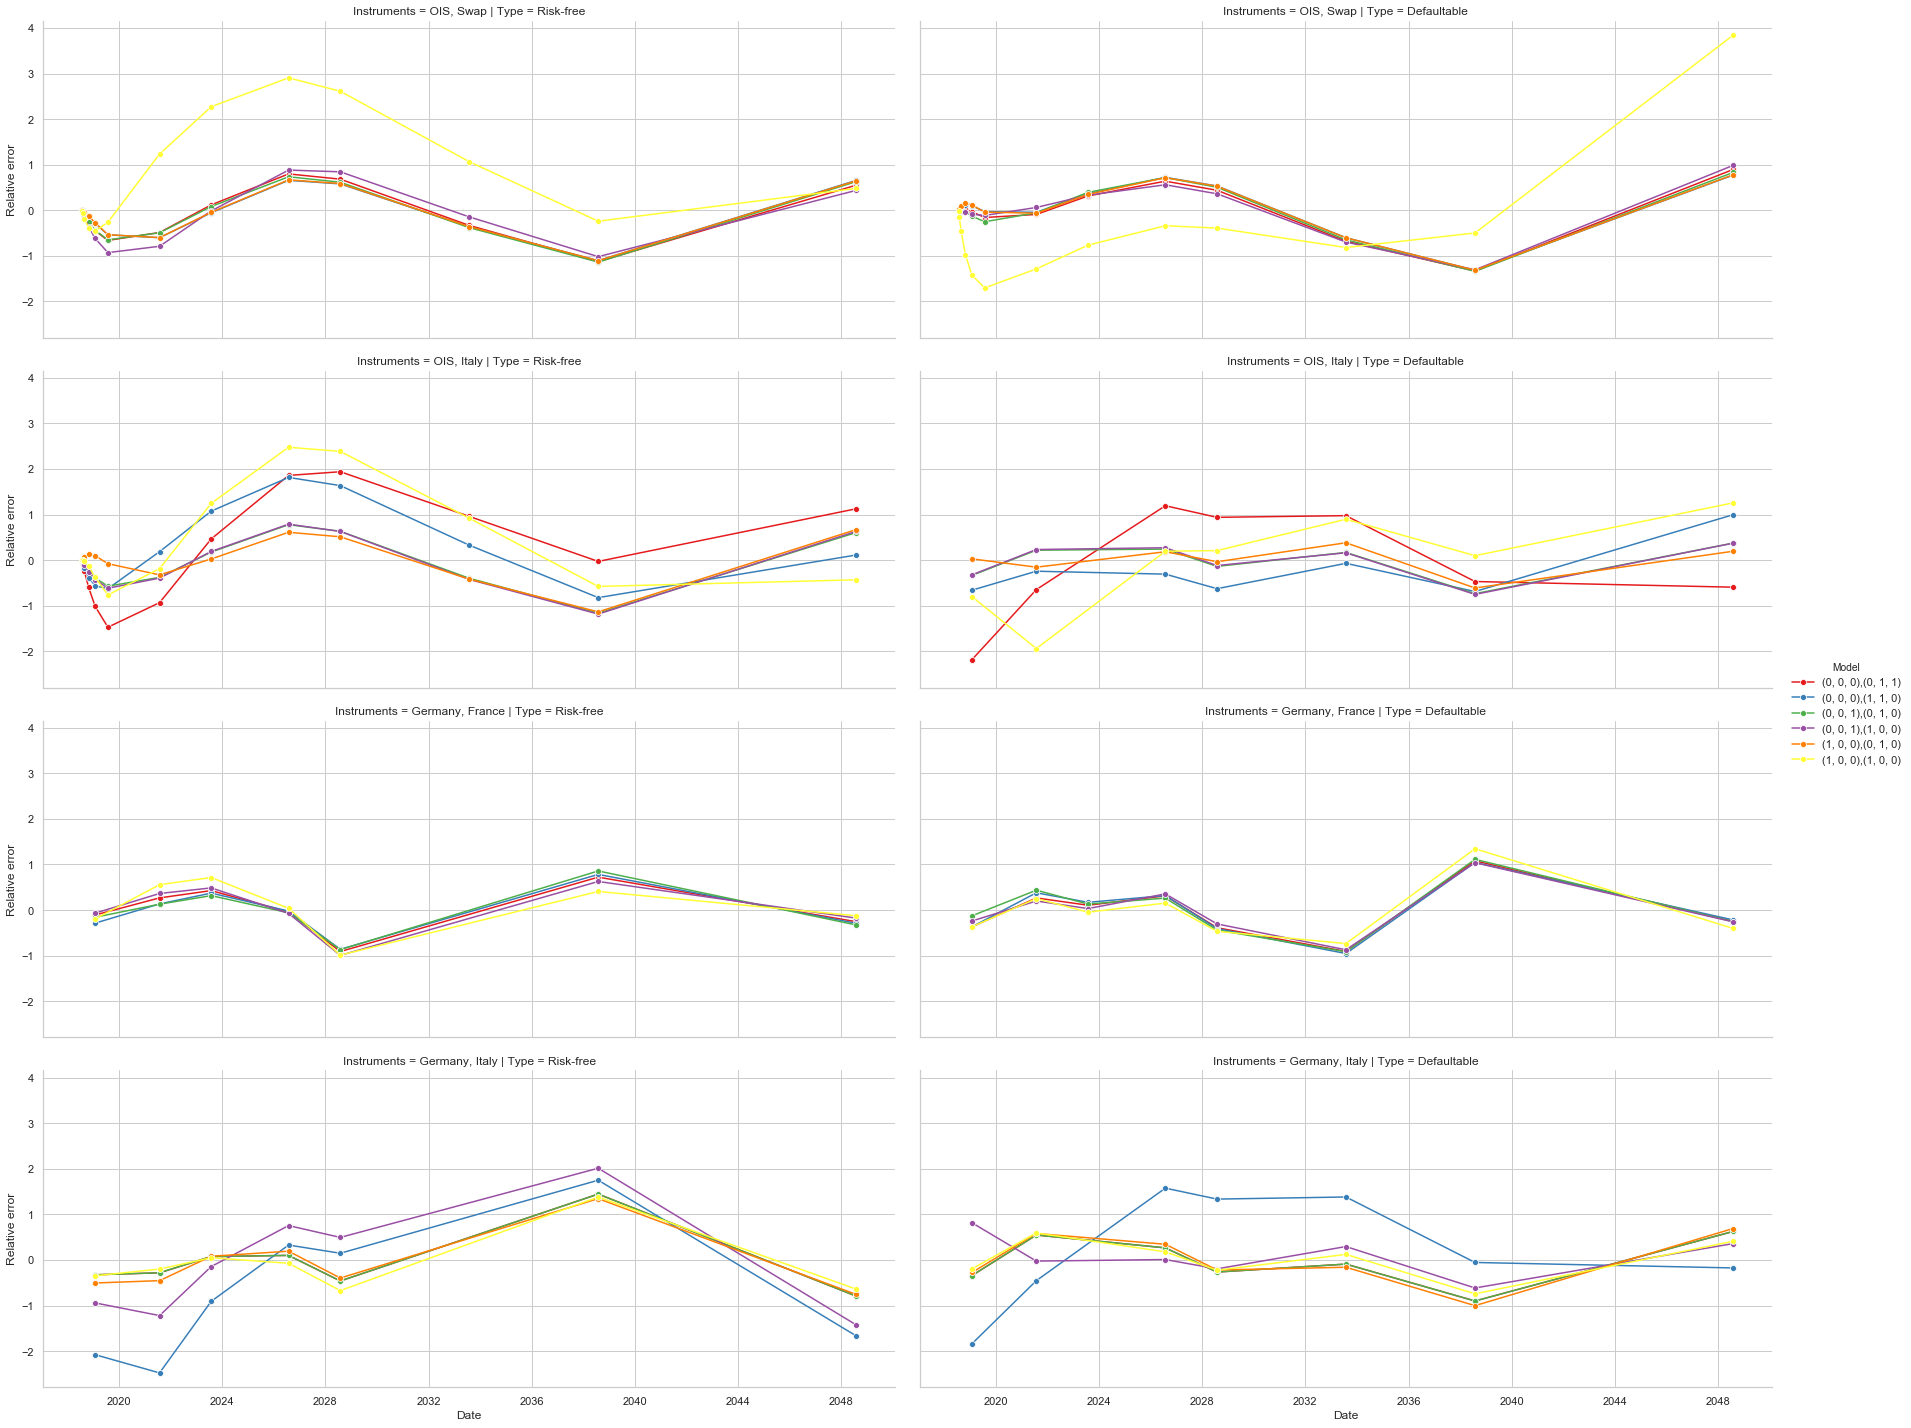

In [50]:
df2 = pd.concat([pd.concat(relative_rf_data, sort=True), pd.concat(relative_risky_data, sort=True)], keys=['Risk-free', 'Defaultable'])
df2 = df2.reset_index()
df2.columns = ['Type', 'Instruments', 'Date'] + list(df2.columns)[3:]
df2 = pd.melt(df2, value_vars=df2.columns[3:], id_vars=df2.columns[:3], var_name='Model', value_name='Relative error')

g = sns.FacetGrid(df2, 
                  col='Type', 
                  row='Instruments', 
                  hue='Model', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1',
                  row_order=['OIS, Swap', 'OIS, Italy', 'Germany, France', 'Germany, Italy'])
g = (g.map(sns.lineplot, 'Date', 'Relative error', marker='o').add_legend())

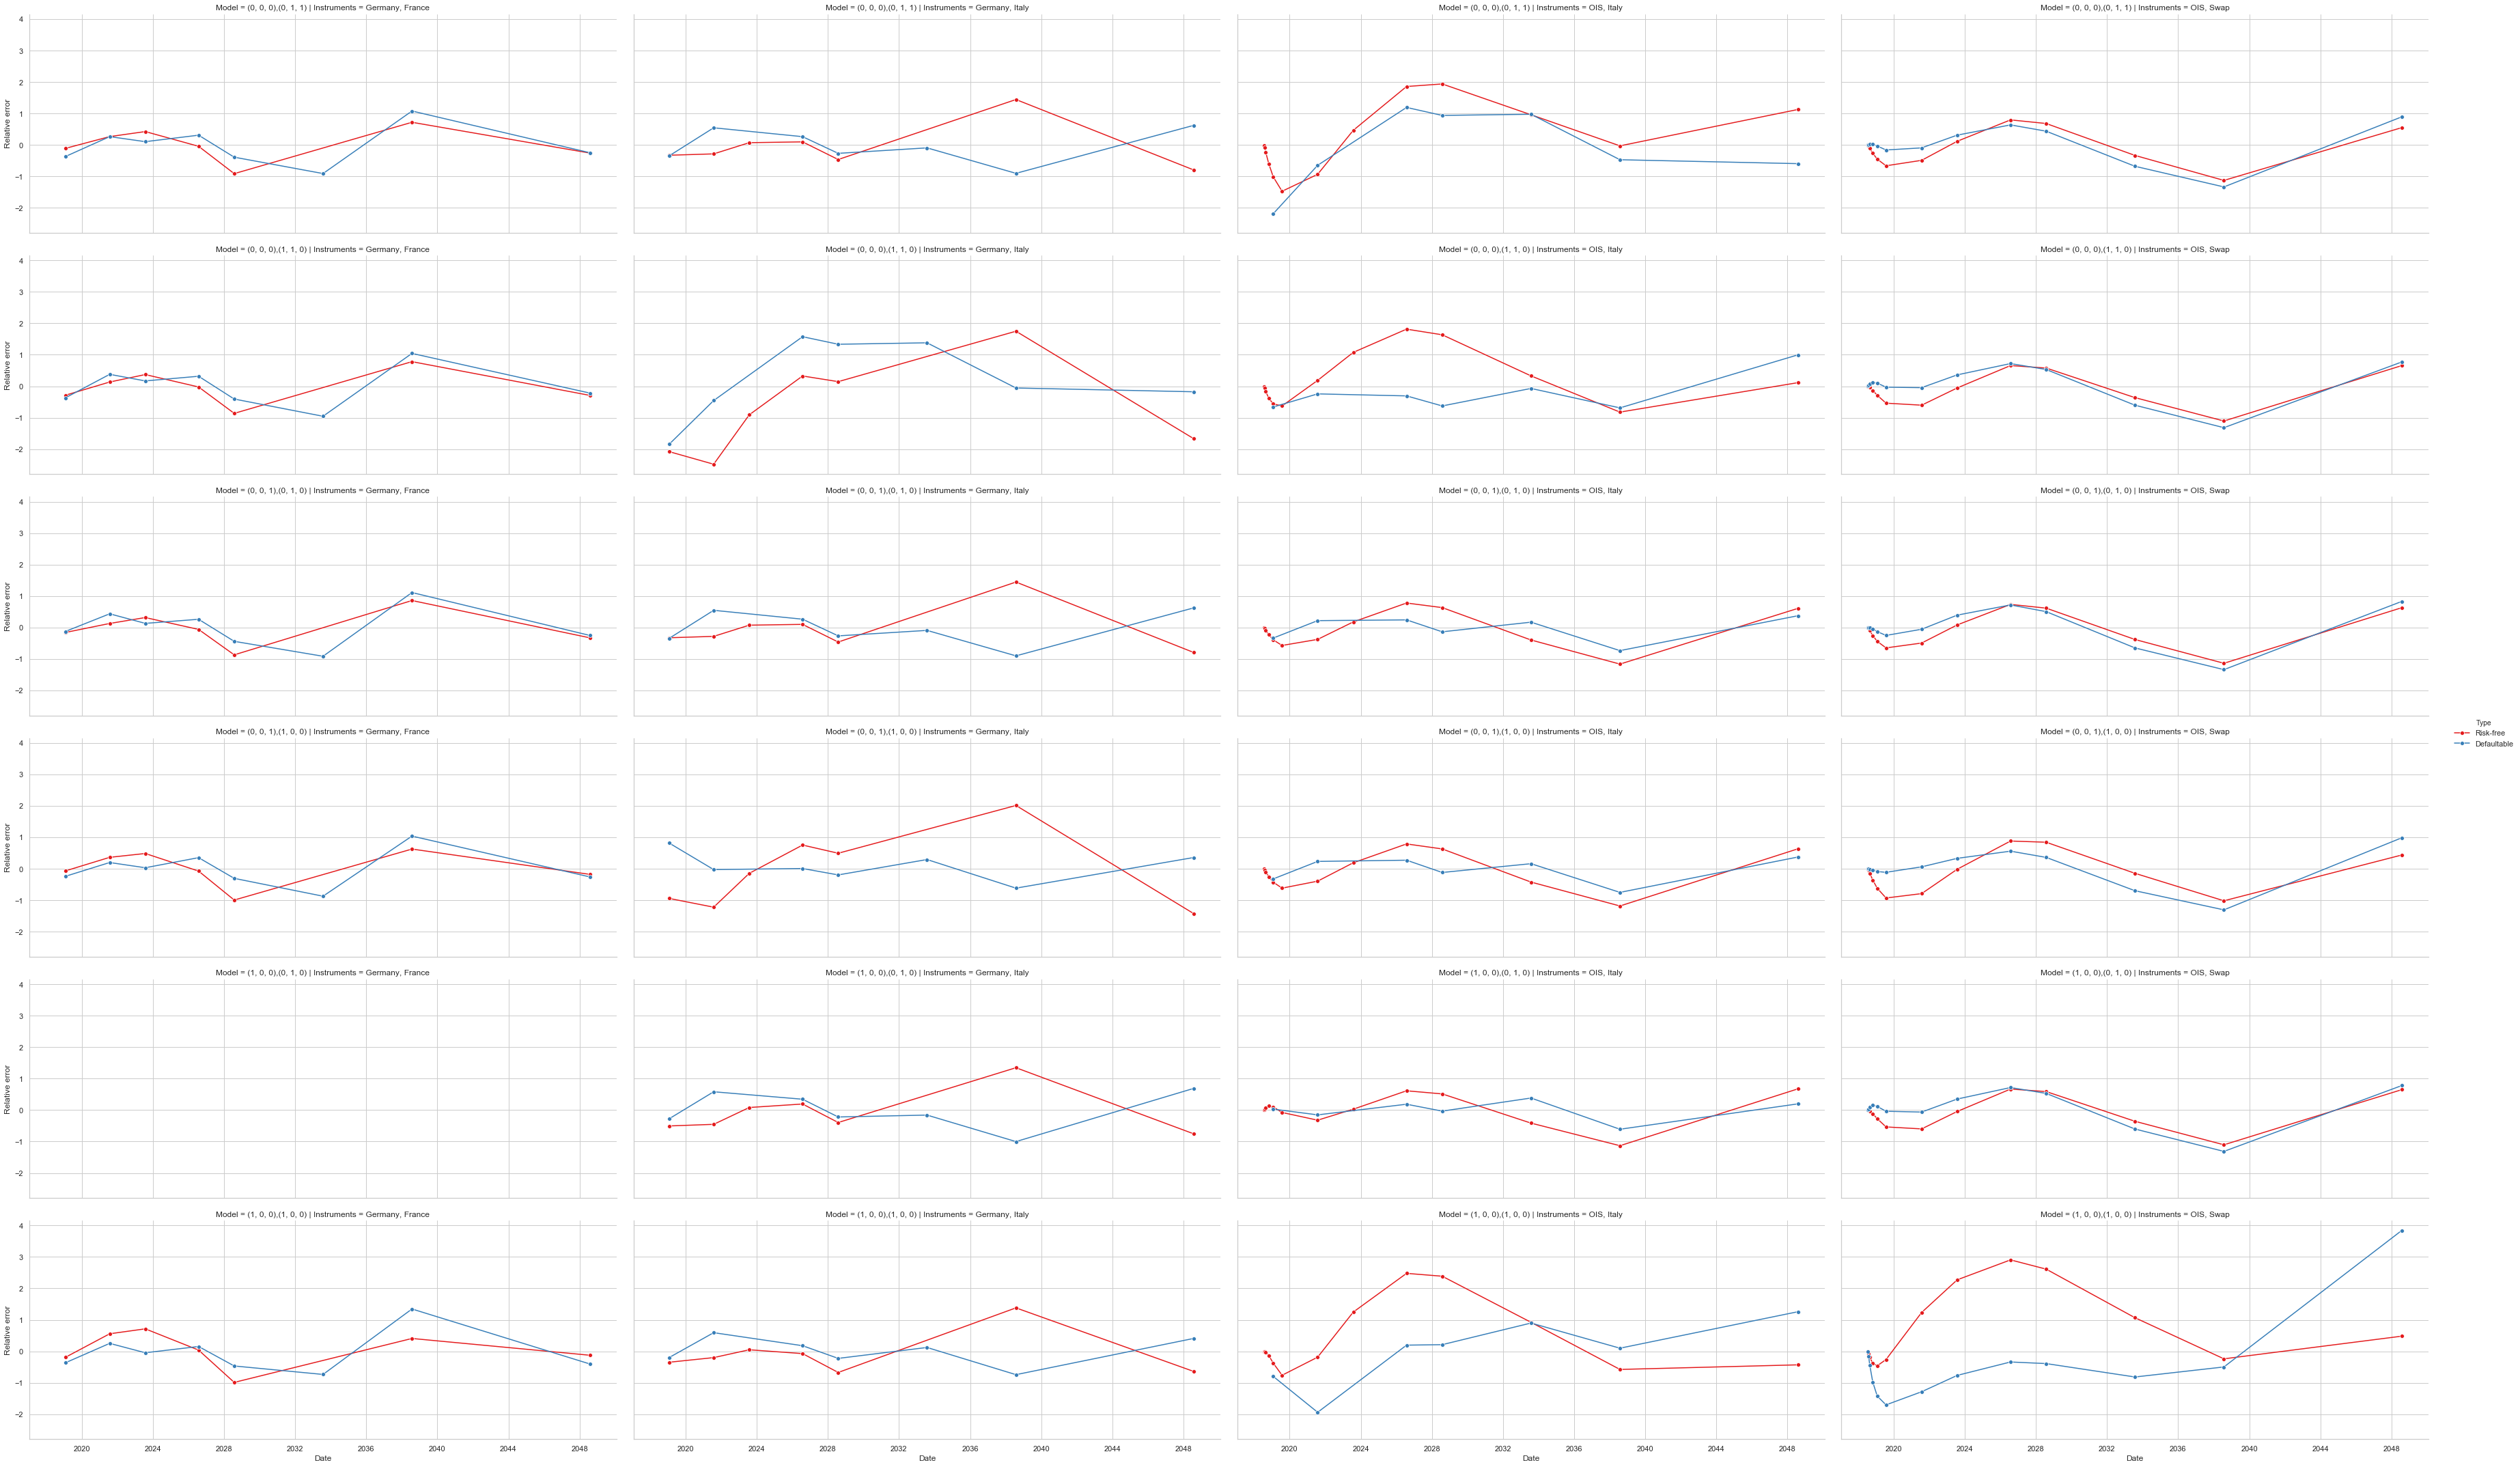

In [52]:
g = sns.FacetGrid(df2, 
                  col='Instruments', 
                  row='Model', 
                  hue='Type', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1')
g = (g.map(sns.lineplot, 'Date', 'Relative error', marker='o').add_legend())

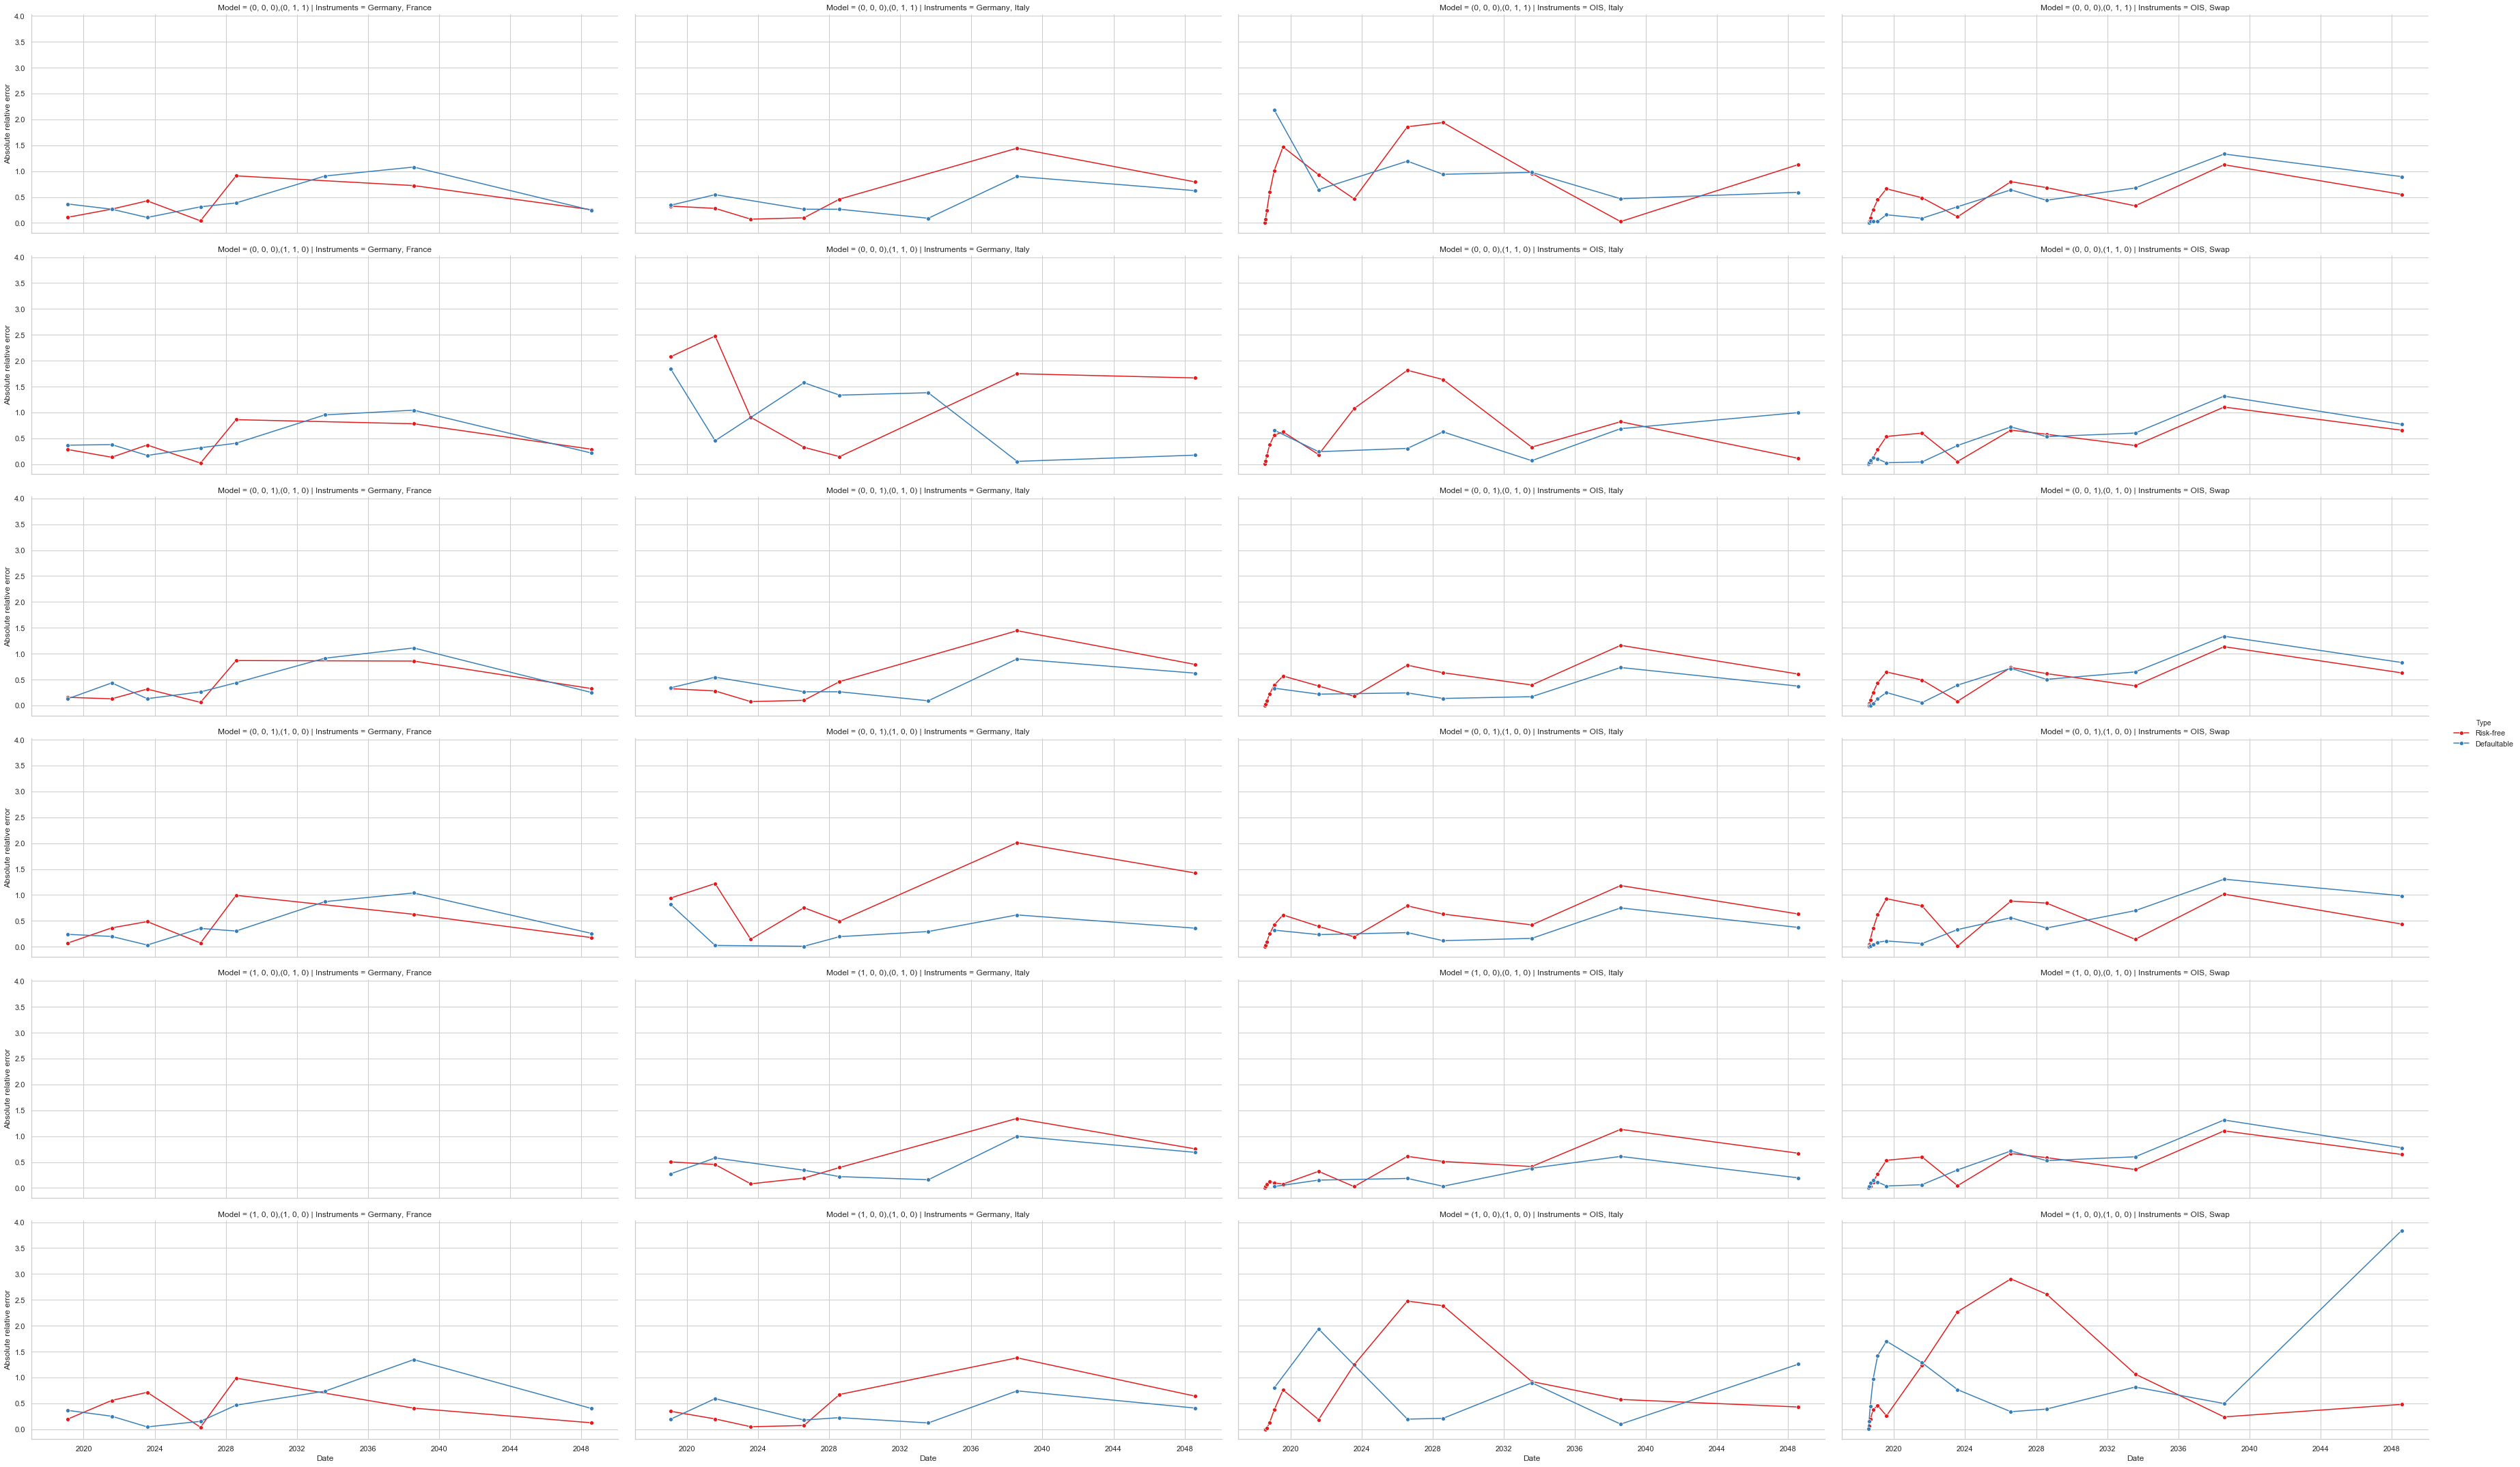

In [53]:
g = sns.FacetGrid(df, 
                  col='Instruments', 
                  row='Model', 
                  hue='Type', 
                  height=5, 
                  aspect=2.5, 
                  palette='Set1')
g = (g.map(sns.lineplot, 'Date', 'Absolute relative error', marker='o').add_legend())

In [73]:
df2.pivot_table(index=['Model', 'Instruments', 'Date'], columns='Type', values='Relative error')

Type                                            Defaultable  Risk-free
Model               Instruments     Date                              
(0, 0, 0),(0, 1, 1) Germany, France 2019-01-30       -0.368     -0.108
                                    2021-07-30        0.266      0.267
                                    2023-07-31        0.106      0.427
                                    2026-07-30        0.312     -0.041
                                    2028-07-31       -0.387     -0.910
                                    2033-07-29       -0.907        NaN
                                    2038-07-30        1.080      0.722
                                    2048-07-30       -0.245     -0.256
                    Germany, Italy  2019-01-30       -0.343     -0.325
                                    2021-07-30        0.547     -0.282
                                    2023-07-31          NaN      0.074
                                    2026-07-30        0.265      0.100
                                    2028-07-31       -0.265     -0.461
                                    2033-07-29       -0.091        NaN
                                    2038-07-30       -0.900      1.445
                                    2048-07-30        0.625     -0.794
                    OIS, Italy      2018-07-27          NaN     -0.007
                                    2018-08-06          NaN     -0.078
                                    2018-08-30          NaN     -0.238
                                    2018-10-30          NaN     -0.596
                                    2019-01-30       -2.183     -1.013
                                    2019-07-30          NaN     -1.470
                                    2021-07-30       -0.645     -0.931
                                    2023-07-31          NaN      0.466
                                    2026-07-30        1.194      1.859
                                    2028-07-31        0.940      1.940
                                    2033-07-29        0.977      0.961
                                    2038-07-30       -0.468     -0.027
                                    2048-07-30       -0.592      1.128
                    OIS, Swap       2018-07-27        0.001     -0.003
...                                                     ...        ...
(1, 0, 0),(1, 0, 0) Germany, Italy  2028-07-31       -0.225     -0.672
                                    2033-07-29        0.122        NaN
                                    2038-07-30       -0.742      1.380
                                    2048-07-30        0.410     -0.641
                    OIS, Italy      2018-07-27          NaN      0.000
                                    2018-08-06          NaN     -0.002
                                    2018-08-30          NaN     -0.021
                                    2018-10-30          NaN     -0.134
                                    2019-01-30       -0.798     -0.375
                                    2019-07-30          NaN     -0.761
                                    2021-07-30       -1.938     -0.186
                                    2023-07-31          NaN      1.246
                                    2026-07-30        0.196      2.477
                                    2028-07-31        0.211      2.386
                                    2033-07-29        0.898      0.922
                                    2038-07-30        0.099     -0.576
                                    2048-07-30        1.257     -0.430
                    OIS, Swap       2018-07-27       -0.014     -0.006
                                    2018-08-06       -0.153     -0.067
                                    2018-08-30       -0.443     -0.188
                                    2018-10-30       -0.977     -0.380
                                    2019-01-30       -1.422     -0.460
                                    2019-07-30       -1.702     -0.261
                        

In [73]:
param_dict = {}

for item in def_results:
    if item == 'ios, swap':
        item2 = 'OIS, Swap'
    elif item == 'ios, italy':
        item2 = 'OIS, Italy'
    elif item == 'germany, france':
        item2 = 'Germany, France'
    elif item == 'germany, italy':
        item2 = 'Germany, Italy'
        
    param_dict[item2] = {}
        
    for model in def_results[item]:
        
        params = copy.copy(def_results[item][model]['param'])
        Ms, Ns = model
        model_name = f'({Ms[0]}, {Ms[1]}, {Ms[2]}),({Ns[0]}, {Ns[1]}, {Ns[2]})'
        
        if 'risk_free' in params:
            params.pop('risk_free')
        if 'shift' in params:
            params.pop('shift')
        if 'M' in params:
            params.pop('M')
        if 'N' in params:
            params.pop('N')
               
        for key, value in params.items():
            if key == 'rho':
                value = value[0,1]
                params[key] = np.round(value, 3).astype(float)
                
            elif key not in ('a_m', 'b_m', 'c_i', 'd_i'):
                if isinstance(value, np.ndarray):
                    if value.shape == (1,):
                        value = value[0]
                params[key] = np.round(value, 3).astype(float)
            
        param_dict[item2][model_name] = params
        
    param_dict[item2] = pd.DataFrame(param_dict[item2])
    
index_order = pd.Categorical(['a_m',
                              'b_m',
                              'c_i',
                              'd_i',
                              'delta'
                              'spread'
                              'LGD'
                              'X_0',
                              'alpha',
                              'theta',
                              'sigma'
                              'Y_0',
                              'k',
                              'nu',
                              'rho'], ordered=True)
            


In [74]:
for item, value in param_dict.items():
    value = value.sort_index(level=index_order)
    print(item)
    print('')
    print(value.to_latex(na_rep=''))
    print('')
    
    

OIS, Swap

\begin{tabular}{lllllll}
\toprule
{} & (0, 0, 1),(0, 1, 0) & (0, 0, 1),(1, 0, 0) & (1, 0, 0),(1, 0, 0) & (1, 0, 0),(0, 1, 0) & (0, 0, 0),(0, 1, 1) & (0, 0, 0),(1, 1, 0) \\
\midrule
LGD    &                0.97 &               0.426 &               0.441 &               0.435 &               0.776 &               0.748 \\
X\_0    &                0.01 &               0.047 &               0.001 &               0.013 &                     &                     \\
Y\_0    &              -0.032 &              -0.036 &              -0.033 &              -0.036 &      [-0.032, 0.01] &     [0.012, -0.036] \\
a\_m    &                 [0] &                 [0] &                 [1] &                 [1] &                  [] &                  [] \\
alpha  &                   3 &               0.544 &               0.228 &               2.857 &                     &                     \\
b\_m    &                 [1] &                 [1] &                 [1] &                 [1]

Model
D((0, 0, 0),(0, 1, 1))    0.562353
D((0, 0, 0),(1, 1, 0))    0.582391
D((0, 0, 1),(0, 1, 0))    0.396539
D((0, 0, 1),(1, 0, 0))    0.353020
D((1, 0, 0),(0, 1, 0))    0.354307
D((1, 0, 0),(1, 0, 0))    0.641642
dtype: float64

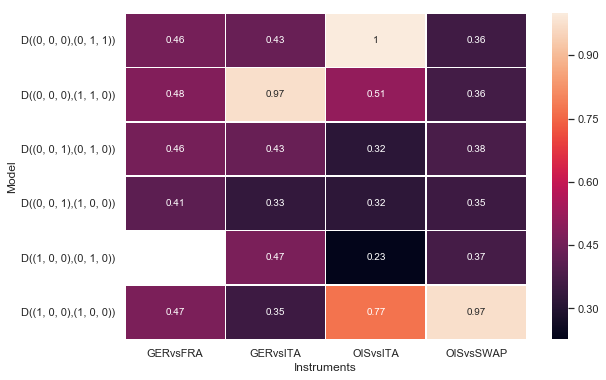

In [13]:
df_def = df.loc[df['Type'] == 'Defaultable']
errors_def = df_def.pivot_table(index=['Instruments'], columns=['Model'], values='Absolute error').mean(level=0).transpose().sort_index()


f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(errors_def, annot=True, linewidths=.5, ax=ax)

errors_def.mean(axis=1)

Instruments                         GERvsFRA  GERvsITA  OISvsITA  OISvsSWAP
Model                  Type                                                
D((0, 0, 0),(0, 1, 1)) Base         0.390132  0.497227  0.824176   0.431228
                       Defaultable  0.458864  0.433774  0.999766   0.357006
D((0, 0, 0),(1, 1, 0)) Base         0.392456  1.336195  0.598205   0.386044
                       Defaultable  0.481701  0.973267  0.511754   0.362842
D((0, 0, 1),(0, 1, 0)) Base         0.388091  0.497231  0.418898   0.427016
                       Defaultable  0.458894  0.433623  0.315759   0.377880
D((0, 0, 1),(1, 0, 0)) Base         0.398124  0.998931  0.435842   0.478687
                       Defaultable  0.412318  0.330435  0.318532   0.350794
D((1, 0, 0),(0, 1, 0)) Base              NaN  0.532924  0.316147   0.382564
                       Defaultable       NaN  0.467230  0.226972   0.368719
D((1, 0, 0),(1, 0, 0)) Base         0.432118  0.480271  0.732079   0.936326
                       Defaultable  0.470722  0.352142  0.770980   0.972726